<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [1]:
#@title Current Date
Today = '2021-09-08' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "18213561" #@param {type:"string"}
Student_full_name = "Pierluigi Riti" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Libraries

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
from scipy.special import erf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az
from scipy.io import loadmat
import pymc3 as pm
import random
from IPython.display import HTML
import pickle
import theano as tt
import cv2
from sklearn.utils import shuffle
from skimage.color import rgb2gray

In [6]:
# Setting a seed:
np.random.seed(123)

## Dataset

The MINST dataset is downloaded from Kaggle, https://www.kaggle.com/oddrationale/mnist-in-csv.<br> 
The dataset consist on two file .CSV, the _minst_train.csv_, this contain 10.000 example, and the _minst_test.csv_ this file cointains 60.000 example.<br>
Both the file are uploaded in my Google Drive and in this way I can access on the file via Google Colab.

### Loading the MNIST dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Path, copy the path from your Drive
Path = '/content/drive/MyDrive/Colab Notebooks/'

# MNIST Data
train_data = Path + 'mnist_train.csv'
test_data = Path + 'mnist_test.csv'

# train data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values
print(X_train.shape)

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values
print(X_test.shape)

(60000, 784)
(10000, 784)


The MINST dataset is essentially a set of image, this means the value can be from 0 to 255, most of the Machine Learning algorithm works with value 0 to 1, the next step is to convert the range from 0 to 255 to 0 to 1

In [9]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)
print(minv,maxv)
print(len(X_train))

0.0 1.0
60000


# **Preprocessing Data Function**

### Description of Data:

For better work with the data, let's describe the data, we want to see the shape of the dataset, and the number of **_classes_** and **_features_**

In [11]:
# Number of examples
n_train =  len(X_train)
n_test =  len(X_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1]

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)

Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10


### Class Distribution:

The first step for calculate a probability is understand what is the distribution of the data, for do that, let's print the distribution of the class

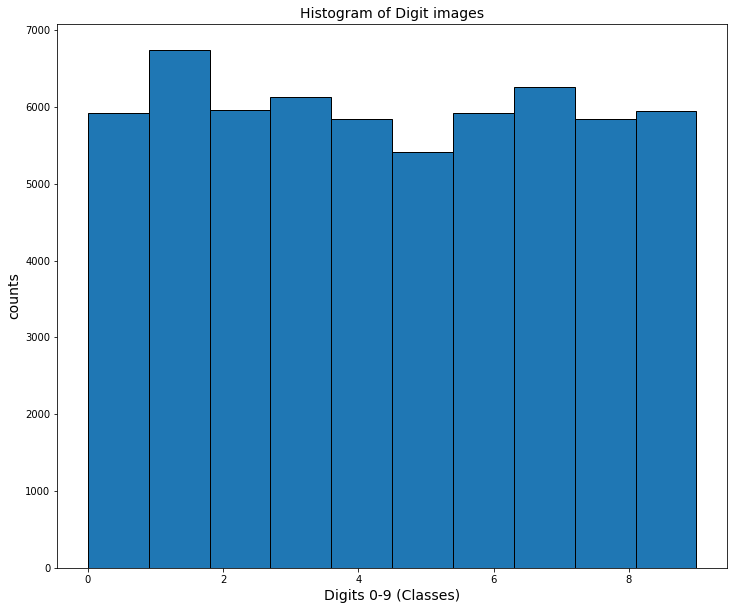

In [12]:
fig, ax = plt.subplots(figsize=(12,10))
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, n_classes, ec='black')
ax.set_xlabel('Digits 0-9 (Classes)', fontsize = 14)
ax.set_ylabel('counts', fontsize = 14)
ax.set_title(r'Histogram of Digit images', fontsize = 14)
plt.show()

How we can see, the diagram show some difference about the distribution of the digits, the _5_ is the digit with less occurence, on the other side the _1_ is the digit with most occurence.  

## Downsampling

The diagram show cleary an imbalanced dataset, this because the class 1 and 5 have some significant difference.<br>
In this case we use a technique called **_Drownsampling_** the normal drowsampling is done select some example from the class with the majority from where we select a lower subset of data, in our case, we select a subset from 3 random classes of our dataset, this because essentially all the classes have difference against each other.


### Randomly selecting 3 of the 10 Digit Classes

In [13]:
# We select the number of Classes we want:
n_classes = 3

# Empty list to append the random digit classes we select:
classes = []

# We select 3 digits at random and make sure they are unique:
# the alltotal is the total number of the class in the dataset
while len(classes) < n_classes:
    
    # Randomly drawing a digit from 0-9:
    num2choose = np.random.randint(0,10)

    # Append the digit if it's not already in our list of classes:
    if num2choose not in classes: 
        classes.append(num2choose)
        
        
# Sorting the Classes smallest to largest    
classes.sort()
# print classes selected
classes

[1, 2, 6]

In [14]:
# The number of instances we'll keep for each of our 3 digits:
inst_class = 5000

inputs = []
labels = []

# Loop to randomly sample the instances for each digit:
for r in classes:
    imgs = X_train[np.where(y_train==r)[0],:]
    inputs.append(imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:])
    labels.append(np.ones(inst_class)*r)
    
# Shaping inputs and labels in the right format    
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)

print(X_train.shape)
print(y_train.shape)

(15000, 784)
(15000,)


New Classes Distribution

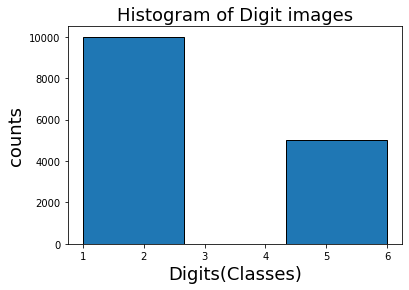

In [15]:
fig, ax = plt.subplots()

ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, n_classes, ec='black', align='mid')
ax.set_xlabel('Digits(Classes)', fontsize = 18)
ax.set_ylabel('counts', fontsize = 18)
ax.set_title(r'Histogram of Digit images', fontsize = 18)
plt.show()

In [16]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

Text(0.5, 1.0, 'Original Digits')

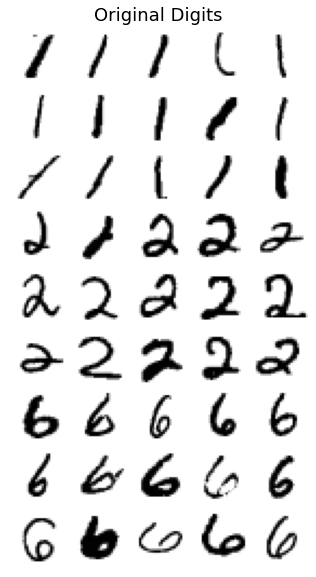

In [17]:
# Show a few instances from each Digit:
plt.figure(figsize=(12,10))
label_indices = []
# Selecting a few label indices from each of the 3 classes to show:
for i in range(30):
    # take index randomly chosen
    label_indices = np.hstack([np.random.choice(np.where(y_train==label)[0], size=15) for label in classes])
    # choose the image according to the index
    image = X_train[label_indices[i] - 1]

# Plotting 'original' image
plot_digits(X_train[label_indices],images_per_row=5)
plt.title("Original Digits", fontsize=18)

###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [18]:
### Split tha dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

In [19]:
# print shape of your validation and training set
print(y_val.shape, y_train.shape)
print(X_val.shape, X_train.shape)



(3000,) (12000,)
(3000, 784) (12000, 784)


### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

In [20]:
import sklearn.preprocessing

y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train.reshape(-1,1))
np.set_printoptions(threshold=100)
y_2_bin

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

### General-Recipe ML

In [21]:
# model
model_log = LogisticRegression(random_state=0, 
                               max_iter=2000, C=100, 
                               solver='lbfgs', 
                               multi_class='multinomial').fit(X_train, y_train)

# Classification:
y_pred_log = model_log.predict(X_val)
y_pred_logi_prob = model_log.predict_proba(X_val)

# Maybe taking the maximum probability 
# in any of the classes for each observation
prob_classmax = np.max(y_pred_logi_prob,axis=1)

# Computing the Accuracy:
accuracy_score(y_pred_log, y_val)

0.974

The accuracy of the model is 97.4%, this is quite good we have a good prediction with the dataset we have.<br>
The model give us a general precision, we have 3 digits, and if we want to know better about the accurancy score, we can calculate the F1-Score for the different digit. We can do that using the classification_report function form Scikit-Learn

In [22]:
# Calculate precision, recall and F1-Score for our model for each digit
Digits = []
for digit in classes:
  Digits.append("Digit %s " % digit)

print (classification_report(y_val, y_pred_log, target_names=Digits, digits=3))

              precision    recall  f1-score   support

    Digit 1       0.982     0.987     0.984       964
    Digit 2       0.968     0.962     0.965      1026
    Digit 6       0.972     0.974     0.973      1010

    accuracy                          0.974      3000
   macro avg      0.974     0.974     0.974      3000
weighted avg      0.974     0.974     0.974      3000



When we build a model, the value of accuracy at all is not enough to solve our problem.<br>
In this case we can use the **_Precision_**,**_Recall_** and **_f1-score_** for evaluate our model.<br>First to define the formula for the _precision_, _recall_ and _f1-score_ let's define the value used in the formula:<br>

*   _TP_= True Positive
*   _TN_= True Negative
*   _FP_= False Positive
*   _FN_= False Negative<br>

The starting point for evaluate the model is the **_Accurancy_**, this value is the most simple to calculate and how we can see for our model is 97.4%.<br>The formula for calculate the accurancy is:<br>
**TP+TN/TP+FP+TN+FN**<br>The second value we can calculate is the **_precision_** how we can see for 
the table the precisio is 98.2% for the digit 1 and 2, and 97.2% for the digit 6.<br>The formula for calculate the _precision_ is:<br>**TP/TP+FP**<br>
the **_recal_** is calculated with the formula:<br>**TP/TP+FN**<br>
The **_f1-score_** is calculated with the formula:<br>**2*((precision*recall)/(precision+recall))**



### Probabilistic Multinomial Logistic Regression:

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


In [23]:
## We use LabelBinarizer to transfor classes into counts
nf = X_train.shape[1]
# number of classes
nc = len(classes)
# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)


with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_train,β1) + α1
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)


In [24]:
with multi_logistic:
    #approx = pm.fit(300000, method='advi') # takes longer
    approx = pm.fit(30000, method='advi')

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 6,982.9


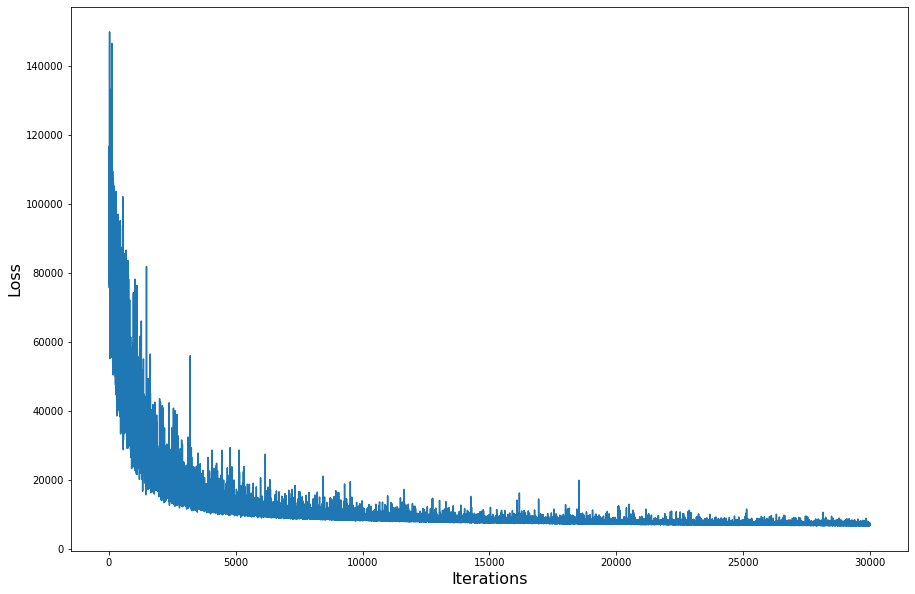

In [25]:
plt.figure(figsize=(15,10))
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.plot(approx.hist)

How we can see when we run 30.000 iteration the loss function reach his minimun, observing the histogram, we can see the number of minum iteration to reach the optimal loss value is around 8000 iteration. The Pymc3 is run with an ADVI method, Automatic Differentiation Variational Interference, this method offer the power of the Variational Inference for approximates the Bayesian model, but add an automatic way to calculate the inference.

In [26]:
# dd = 3000
dd = 300
posterior = approx.sample(draws=dd)

The _sample_ function run over 300 example, this get the posterior based on the example we identify.

test image #10
posterior sample #100
true class= 6.0
classes: [1, 2, 6]
estimated prob= [0. 1. 0.]


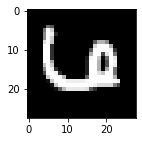

In [27]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

#select an image in the test set
i = 10 
#i = random.randint(0, dd)

#select a sample in the posterior
s = 100 
#s = random.randint(0, dd)


beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
image = X_val[i,:].reshape(28,28) # because the image are 28x28 pixel, I need to reshape with 28,28
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

The _softmax_ is used to normalize the output in a multinomial logistic regression and is often used as at the last activation function in a Neural Network. The _softmax_ function is used to take the input and to normalize in a probability distribution, in our case the software return a missclassified probability, the digit is classified as a 2, not as a 6, this because the image is rotate of 90 degree and this can lead to a wrong classification. 

In [28]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in range(X_val.shape[0]):
    val=np.zeros((1,len(classes)))
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_val[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))

In [29]:
from collections import Counter
# Count the different prediction in the Bayesian
print(Counter(y_pred_Bayesian))

Counter({2: 1017, 1: 1016, 0: 967})


In [30]:
# recall the classes we are using
print(classes)

[1, 2, 6]


In [31]:
# prediction array (using classes)
nn = 10 # just an example
np.array(classes)[y_pred_Bayesian[0:nn]]

array([1, 6, 6, 1, 2, 1, 6, 6, 2, 1])

In [32]:
# using validation: y_val
print("Accuracy=", accuracy_score(np.array(classes)[y_pred_Bayesian], y_val))

Accuracy= 0.9833333333333333


The Bayesian accurancy is now 98.2% this accurance is higher of the logistic regression, this is because we use a bigger number of test in our Baysen and this improve the accurancy of the model.

# **Selecting different instances¶**

In [33]:
y_predB=[]

for i in range(X_val.shape[0]):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

In [34]:
# prediction array
mm = 10
y_predB[0:mm,:]

array([[0.        , 0.92571611, 0.17950549],
       [2.        , 0.99903178, 0.        ],
       [2.        , 0.98838855, 0.08137704],
       [0.        , 0.99882026, 0.        ],
       [1.        , 1.        , 0.        ],
       [0.        , 0.99948774, 0.        ],
       [2.        , 0.99999983, 0.        ],
       [2.        , 0.99999847, 0.        ],
       [1.        , 0.99870514, 0.        ],
       [0.        , 0.99983434, 0.        ]])

In [35]:
#sorting in descending order
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[1.        , 0.50887071, 0.5       ],
       [2.        , 0.50531033, 0.49998889],
       [1.        , 0.48278873, 0.49998889],
       [2.        , 0.50793379, 0.49998889],
       [1.        , 0.50938419, 0.49995555],
       [2.        , 0.48701378, 0.49989999],
       [0.        , 0.4997574 , 0.49959984],
       [0.        , 0.52326246, 0.49959984],
       [1.        , 0.52840248, 0.49945526],
       [2.        , 0.52376967, 0.49928838]])

In [36]:
#probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_log != y_val]

array([1.        , 0.9999908 , 0.99995891, 0.99981347, 0.98079807,
       0.93164146, 0.8711765 , 0.9707614 , 0.99999997, 0.51284719,
       0.92689108, 0.99915921, 0.68499082, 0.99888392, 1.        ,
       0.58931519, 0.93713587, 0.99980593, 0.92434844, 0.86367748,
       0.99999999, 0.74996053, 0.99999971, 0.99946989, 0.9999984 ,
       0.9846901 , 0.99772614, 0.99996548, 0.99977199, 0.8901548 ,
       0.85530461, 0.74915123, 0.96661533, 0.97656184, 0.67265709,
       0.63616862, 0.95337935, 0.96553302, 0.96006696, 1.        ,
       0.99699667, 0.9995172 , 0.97156277, 0.63328865, 0.99834075,
       0.98800818, 0.95565749, 0.97789174, 0.68079014, 0.99953723,
       0.93557243, 0.99999202, 0.99911817, 0.52590047, 0.99511685,
       0.99999959, 1.        , 0.9620433 , 0.89518553, 0.86479906,
       0.99530315, 0.60188496, 0.67741465, 0.9999999 , 0.98790068,
       1.        , 0.42761895, 0.9746156 , 0.99838855, 0.95922805,
       0.99944298, 0.99566734, 0.66589747, 0.67146108, 0.97809

In [37]:
y_predB[y_pred_log != y_val,:]

array([[1.        , 0.99998244, 0.        ],
       [2.        , 0.71355016, 0.44221664],
       [1.        , 0.73157179, 0.44221664],
       ...,
       [1.        , 0.96704398, 0.1280191 ],
       [1.        , 0.87355036, 0.31288976],
       [1.        , 0.5294702 , 0.49928838]])

In [38]:
## Difficult & easy instances

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_log[easy[0:100]], y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_log[difficult[0:100]], y_val[difficult[0:100]]))

Accuracy in easy instances = 1.0
Accuracy in difficult instances = 0.67


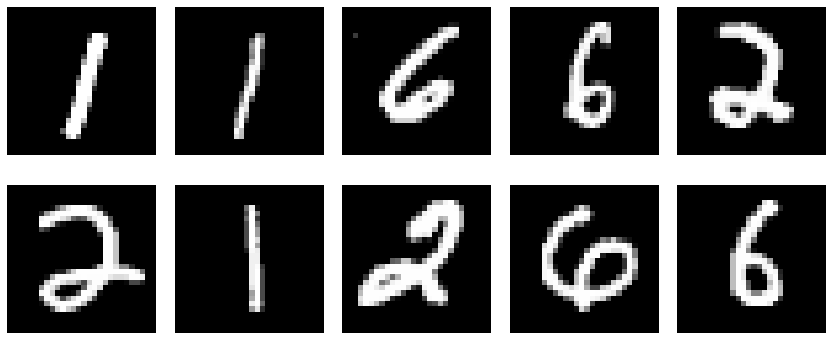

In [39]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

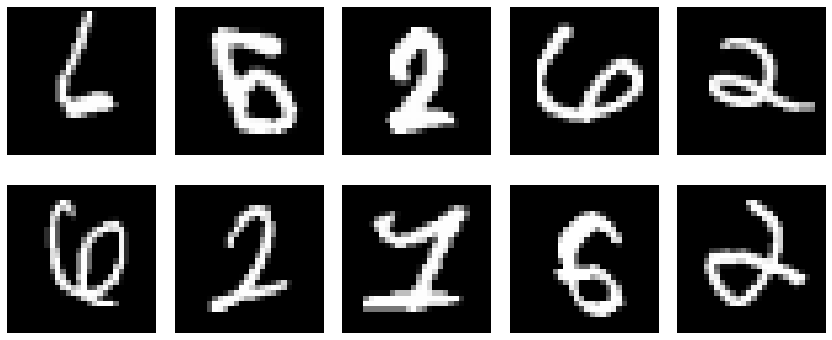

In [40]:
# show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

In [41]:
# Re-run of multinomial logistic regression without difficult samples, 
# but varying the number of difficult samples
results = []
for i in list(np.arange(100, 3000, 100)):
  # model
  model_log = LogisticRegression(random_state=0, 
                                 max_iter=2000, 
                                 C=100, solver='lbfgs', 
                                 multi_class='multinomial').fit(X_train[easy[0:i]], 
                                                                y_train[easy[0:i]])

  # Classification:
  y_pred_log = model_log.predict(X_val)
  y_pred_logi_prob = model_log.predict_proba(X_val)

  # Maybe taking the maximum probability 
  # in any of the classes for each observation
  prob_classmax = np.max(y_pred_logi_prob,axis=1)

  # Computing the Accuracy:
  accuracy_score(y_pred_log, y_val)
  results.append (accuracy_score(y_pred_log, y_val))

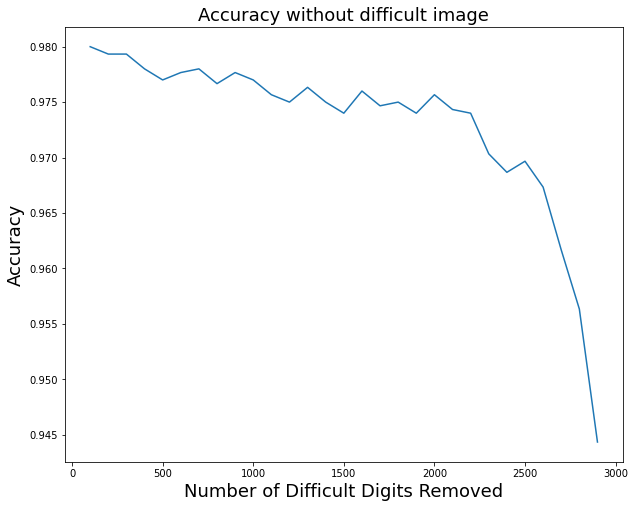

In [42]:
# Graphing the varying effects on accuracy of 
# removing varying amounts of difficult to classify samples
results.reverse()
plt.figure(figsize=(10,8))
plt.plot((list(np.arange(100, 3000, 100))), results)
plt.title('Accuracy without difficult image',fontsize=18)
plt.xlabel('Number of Difficult Digits Removed',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.show()

In [43]:
# Run the multi logistic without the difficult image
model_log = LogisticRegression(random_state=0, 
                               max_iter=2000, 
                               C=100, 
                               solver='lbfgs', 
                               multi_class='multinomial').fit(X_train[easy[0:2500]], 
                                                              y_train[easy[0:2500]])

# Classification:
y_pred_log = model_log.predict(X_val)
y_pred_logi_prob = model_log.predict_proba(X_val)

# Maybe taking the maximum probability 
# in any of the classes for each observation
prob_classmax = np.max(y_pred_logi_prob,axis=1)

# Computing the Accuracy:
accuracy_score(y_pred_log, y_val)

0.977

## Summary

The MINST dataset is a well know dataset, the dataset show some inbalanced data, in particular the digit 1 and the 5. The inbalance is not to high, and this allowed to select some random digit. In my case the classes choose are 1,2 and 6. 
The Traffic Sign notebook it was a very useful guide for the Etivity, and Colab help me to bypass the hardware limitation of my laptop.<br>The _Logistic Multinomial Regression_ as a classifier show an initial accurancy of 97%, this dataset cointains some difficut images.<br>The Pymc3 model Bayesn it's trained with 30000 iteration, this show the loss go down from over 140000 to 6000 circa, the minimun value for the loss is reach around 10000 iteration.<br>When I try the _softmax_ to classify a random image, the model missclassify the image, this depend because the number is rotate of 90 degrees and this make difficult to classify the image.<br>
When I try the Baysen classifier, with the posterior, and 300 sample on the model, the accurancy for the model it was around 98%, this is probably because of the high number of iteration,and because of that the model is better to classify the model.<br> When the difficult image was removed, the same _Logistic Multinomial Regression_ score a little better reaching the 97.7%, this result was made with only 2000 iteration, and then show a better classification is compared with the Baysen, in the case of the Baysen we have 30000 iteration.<br>**Conclusions:**<br>


*   Multinomial Logistic Regression is a very solid algorithm, this help to train a model and classify a mulitnomial dataset, like for example the MINST, where we don't have a simple Linear Classification.
*   Bayesian prediction are very good, in particular if we use a huge number of iteration, in our example I use 30000 example, this take a very long time to be trained but give a vegy good result in term of classification.
*   In order to improve the classification with the Multinomial Logistic regression, and maintain a low number of iteration, is better to remove the difficult data from the model, this help to better classify the data


**References**

Joshi R. (2016) "Accuracy, Precision, Recall & F1 Score: Interpretation of Performance Measures", https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/

Salvatier J., Wiecki T., Fonnesbeck C., (2018) "Getting started with PyMC3" https://docs.pymc.io/notebooks/getting_started.html

Dato-On D., (2018) "The MNIST dataset provided in a easy-to-use CSV format" https://www.kaggle.com/oddrationale/mnist-in-csv?select=mnist_test.csv

Google, (2020) "Imbalanced Data" https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data

Alp Kucukelbir, Rajesh Ranganath, Andrew Gelman, David M. Blei, (2015) "Automatic Variational Inference in Stan" https://arxiv.org/abs/1506.03431







In [45]:
%%capture
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('ET5003_Etivity_1_Pierluigi_Riti_18213561.ipynb')